<a href="https://colab.research.google.com/github/nimab16/Real_Fake_Face/blob/main/MobileNetV2_real_vs_fake_face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title restart Colab { display-mode: "form" }
# This only needs to be done once per notebook.
import os

def restart_runtime():
  os.kill(os.getpid(), 9)


restart_runtime()

In [ ]:
#@title Mount the content of google drive { display-mode: "form" }

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Import libraries { display-mode: "form" }

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential
import matplotlib.pyplot as plt
import tensorflow as tf
# import split-folders
import numpy as np
import cv2
import os, shutil


In [ ]:
! unzip /content/drive/MyDrive/Real_fake/archive.zip -d /content/drive/MyDrive/Real_fake

In [ ]:
os.mkdir(TRAIN_DIR)
os.mkdir(TRAIN_DIR+'/fake')
os.mkdir(TRAIN_DIR+'/real')

os.mkdir(TEST_DIR)
os.mkdir(TEST_DIR+'/fake')
os.mkdir(TEST_DIR+'/real')

In [ ]:
# Configuration

DATASET_DIR = '/content/drive/MyDrive/Real_fake/real_and_fake_face'
TRAIN_DIR = '/content/drive/MyDrive/Real_fake/train_dataset'
TEST_DIR = '/content/drive/MyDrive/Real_fake/test_dataset'

RATE = 0.2 # splitting proportion for training and test datasets

# Parameters for Grid Search

N_EPOCHS = [20] #[20, 40, 100, 200]
OPTIMIZERS = ['adam'] #['adam', 'rmsprop', 'SGD']
DROPOUT_RATES =  [0.1, 0.2, 0.4]
LOSS_FUNCTIONS = ['binary_crossentropy']  #['sparse_categorical_crossentropy', 'kullback_leibler_divergence']    

In [ ]:
# Split image files into test and training set 
# OPTION 2 (copying files into newly created folders)
files_real = os.listdir(f'{DATASET_DIR}/training_real')
files_fake = os.listdir(f'{DATASET_DIR}/training_fake')


# sample from each class to create a test set
np.random.seed(0)
files_real_test = np.random.choice(
    files_real,
    size=round(len(files_real) * RATE),
    replace=False,
    p=None)

files_real_train = list(set(files_real) - set(files_real_test)) #[file for file in files_real if file not in files_real_test] 

files_fake_test = np.random.choice(
    files_fake,
    size=round(len(files_fake) * RATE),
    replace=False,
    p=None)

files_fake_train = list(set(files_fake) - set(files_fake_test)) #[file for file in files_fake if file not in files_fake_test] 

for file in files_real_train:
    shutil.copyfile(DATASET_DIR+'/training_real/'+file, TRAIN_DIR+'/real/'+file) 

for file in files_fake_train:
    shutil.copyfile(DATASET_DIR+'/training_fake/'+file, TRAIN_DIR+'/fake/'+file) 

for file in files_real_test:
    shutil.copyfile(DATASET_DIR+'/training_real/'+file, TEST_DIR+'/real/'+file) 

for file in files_fake_test:
    shutil.copyfile(DATASET_DIR+'/training_fake/'+file, TEST_DIR+'/fake/'+file) 
    

In [ ]:
real = TRAIN_DIR+'/real/'
fake = TRAIN_DIR+'/fake/'

val_real = TEST_DIR+'/real/'
val_fake = TEST_DIR+'/fake/'

real_path = os.listdir(real)
fake_path = os.listdir(fake)

val_real_path = os.listdir(val_real)
val_fake_path = os.listdir(val_fake)

print(real)
print(val_real)

/content/drive/MyDrive/Real_fake/train_dataset/real/
/content/drive/MyDrive/Real_fake/test_dataset/real/


In [ ]:
def load_img(path):
    image = cv2.imread(path)
    image = cv2.resize(image, (224, 224))
    return image[...,::-1]

/content/drive/MyDrive/Real_fake/train_dataset/real/real_00648.jpg


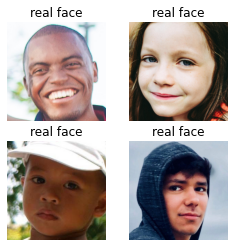

In [ ]:
# Show real face
fig = plt.figure(figsize=(4, 4))
print(real + real_path[0])
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(load_img(real + real_path[i]), cmap='gray')
    plt.title("real face")
    plt.axis('off')

plt.show()

/content/drive/MyDrive/Real_fake/train_dataset/fake/easy_26_1100.jpg


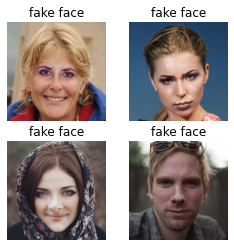

In [ ]:
# Show fake face
fig = plt.figure(figsize=(4, 4))
print(fake + fake_path[0])
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(load_img(fake + fake_path[i]), cmap='gray')
    plt.title("fake face")
    plt.axis('off')

plt.show()

In [ ]:

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')




In [ ]:
# dataset_path = "/content/drive/MyDrive/Real_fake/real_and_fake_face_detection/real_and_fake_face"
train_path = "/content/drive/MyDrive/Real_fake/train_dataset"
val_path = "/content/drive/MyDrive/Real_fake/test_dataset"


In [ ]:

target_size = (96, 96)
train = train_datagen.flow_from_directory(train_path,
                                          class_mode="binary",
                                          target_size=target_size,
                                          batch_size=32,
                                          shuffle=True)

val = train_datagen.flow_from_directory(val_path,
                                          class_mode="binary",
                                          target_size=target_size,
                                          batch_size=32)

Found 1633 images belonging to 2 classes.
Found 408 images belonging to 2 classes.


In [ ]:
# Transfer learning on MobileNetV2
mobilenetV2 = MobileNetV2(input_shape=target_size + (3,),
                          include_top=False,
                          weights='imagenet'
                          )

average_layer = GlobalAveragePooling2D()

model = Sequential([
    mobilenetV2,
    average_layer,
    Dense(256, activation=tf.nn.relu),
    BatchNormalization(),
    Dropout(0.3),
    Dense(2, activation=tf.nn.softmax)
])

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
model.compile(optimizer=Adam(lr=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Schecule for learning rate
def scheduler(epoch):
    if epoch <= 2:
        return 0.001
    elif epoch > 2 and epoch <= 15:
        return 0.0001 
    else:
        return 0.00001

lr_callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
history = model.fit_generator(train,
                    epochs=30,
                    callbacks=[lr_callbacks], validation_data=val)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/30
52/52 [==============================] - 486s 9s/step - loss: 1.2556 - accuracy: 0.5340 - val_loss: 1.3152 - val_accuracy: 0.5074 - lr: 0.0010
Epoch 2/30
52/52 [==============================] - 29s 564ms/step - loss: 0.8629 - accuracy: 0.5689 - val_loss: 2.6117 - val_accuracy: 0.5294 - lr: 0.0010
Epoch 3/30
52/52 [==============================] - 28s 543ms/step - loss: 0.7618 - accuracy: 0.6007 - val_loss: 0.9598 - val_accuracy: 0.5613 - lr: 0.0010
Epoch 4/30
52/52 [==============================] - 28s 540ms/step - loss: 0.7339 - accuracy: 0.6087 - val_loss: 1.1471 - val_accuracy: 0.5098 - lr: 1.0000e-04
Epoch 5/30
52/52 [==============================] - 28s 543ms/step - loss: 0.6991 - accuracy: 0.6020 - val_loss: 1.0129 - val_accuracy: 0.5294 - lr: 1.0000e-04
Epoch 6/30
52/52 [==============================] - 28s 540ms/step - loss: 0.6591 - accuracy: 0.6497 - val_loss: 0.8004 - val_accuracy: 0.5637 - lr: 1.0000e-04
Epoch 7/30
52/52 [==============================] - 29

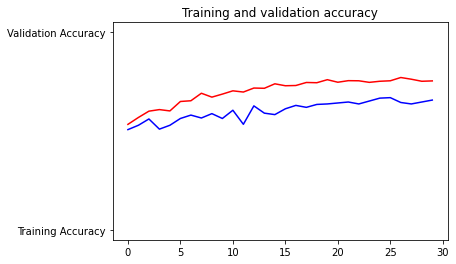

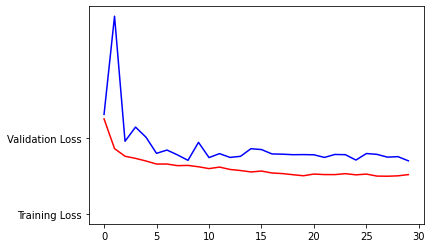

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

In [ ]:
# Unfreezed model will take more space in memeroy, so we need to reduce batch size
batch_size = 32
target_size = (96,96,3)
train_path = train_path
train_gen_ft = train_datagen.flow_from_directory(train_path, target_size=target_size, batch_size=batch_size, class_mode='categorical')
valid_gen_ft = train_datagen.flow_from_directory(val_path, target_size=target_size, batch_size=1, class_mode='categorical', shuffle=False)

Found 1633 images belonging to 2 classes.
Found 408 images belonging to 2 classes.


In [ ]:
# Unfreeze all model's parameters
LR = 1e-2
for layer in mobilenetV2.layers: layer.trainable = True
  
# Reduce learning rate
optimizer = Adam(learning_rate=LR/100)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Load previous weights to continue training on it
model.load_weights('/content/drive/MyDrive/Real_fake/model_val_30_0.31.h5')

In [ ]:
history = model.fit_generator(train,
                    epochs=10,
                    callbacks=[lr_callbacks], validation_data=val)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/10
52/52 [==============================] - 395s 7s/step - loss: 0.7487 - accuracy: 0.5934 - val_loss: 1.5334 - val_accuracy: 0.5270 - lr: 0.0010
Epoch 2/10
52/52 [==============================] - 85s 2s/step - loss: 0.6971 - accuracy: 0.5995 - val_loss: 2.2395 - val_accuracy: 0.5711 - lr: 0.0010
Epoch 3/10
52/52 [==============================] - 85s 2s/step - loss: 0.6353 - accuracy: 0.6601 - val_loss: 1.1313 - val_accuracy: 0.5956 - lr: 0.0010
Epoch 4/10
52/52 [==============================] - 91s 2s/step - loss: 0.6195 - accuracy: 0.6681 - val_loss: 1.1419 - val_accuracy: 0.6127 - lr: 1.0000e-04
Epoch 5/10
52/52 [==============================] - 89s 2s/step - loss: 0.5863 - accuracy: 0.7024 - val_loss: 1.3623 - val_accuracy: 0.5588 - lr: 1.0000e-04
Epoch 6/10
52/52 [==============================] - 88s 2s/step - loss: 0.5722 - accuracy: 0.6993 - val_loss: 1.2486 - val_accuracy: 0.6176 - lr: 1.0000e-04
Epoch 7/10
52/52 [==============================] - 87s 2s/step - los

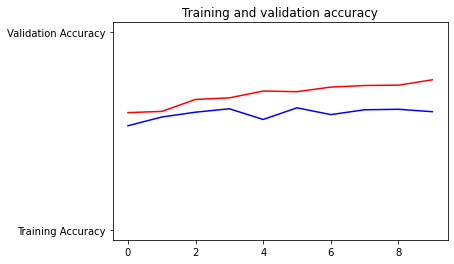

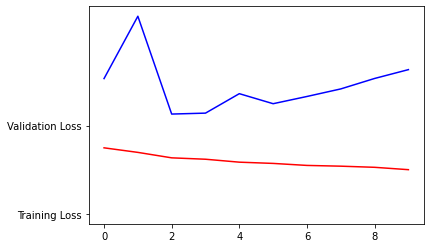

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

In [ ]:
# save a model
model.save("/content/drive/MyDrive/Real_fake/model_val_30_0.3_size.h5")